In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import matplotlib
import pint
from scipy import signal
%matplotlib inline

un = pint.UnitRegistry()
Q = un.Quantity

L_l = 255 * un.millimeter #mm logitud
L_a = 240 * un.millimeter#mm longitud

d_l = 4.6 * un.millimeter#mm diametro
d_a = 4.0 * un.millimeter#mm diametro

er_L = 2 * un.millimeter  #mm
er_d = 0.2 * un.millimeter#mm

r_a = 7850 * un.kilogram/(un.meter**3) #km/m^3 densidad
r_l = 8730 * un.kilogram/(un.meter**3)#km/m^3 densidad

E_l = 110e9 * un.pascal# pa
E_a = 200e9 * un.pascal# pa
#A = area transversal entiendo yo $pi*r^2$

bl = [1.875104, 4.694091, 7.854757, 10.99554]  #beta *L

archivos_laton = []
archivos_acero = []
for i in range(3):
    archivos_acero.append(np.loadtxt('acero_'+ str(i+1) +'.txt', skiprows = 4))
    archivos_laton.append(np.loadtxt('laton_'+ str(i+1) +'.txt', skiprows=  4))
archivos_laton.append(np.loadtxt('laton_4.txt', skiprows=  4))

In [3]:
Izz_l = np.pi*((d_l/2)**4)/4
Izz_a = np.pi*((d_a/2)**4)/4
B_l = np.pi*((d_l/2)**2)*r_l #El factor q va dividiendo en w
B_a = np.pi*((d_a/2)**2)*r_a #El factor q va dividiendo en w

#son las omwgas teoricas
w_l = []
w_a = [] 
for i in bl:#ver si bl es igual para ambos o no
    w_l.append((np.sqrt(E_l*Izz_l/B_l)*(i/L_l)**2).to(1/un.second)) 
    w_a.append((np.sqrt(E_a*Izz_a/B_a)*(i/L_a)**2).to(1/un.second))

<IPython.core.display.Javascript object>


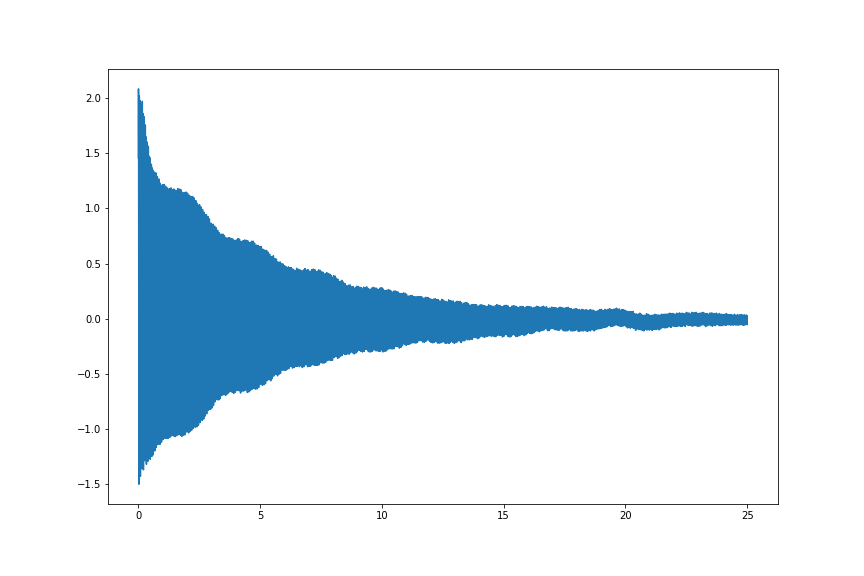

In [6]:
#importo las omwgas teoricas
w_l = []
w_a = [] 
for i in bl:#ver si bl es igual para ambos o no
    w_l.append((np.sqrt(E_l*Izz_l/B_l)*(i/L_l)**2).to(1/un.second)) 
    w_a.append((np.sqrt(E_a*Izz_a/B_a)*(i/L_a)**2).to(1/un.second))
    
    
#primero grafico los datos del acero
%matplotlib nbagg
data = np.array(archivos_laton[2])

fig, ax = plt.subplots(1, figsize=(12,8))

t_in=0
t_fin=25000
data = data[t_in:t_fin,:]
data[:,1] = data[:,1] - np.mean(data[:,1]) #le saco la componente constante a la señal
data[:,0] = data[:,0] - data[0, 0] #le resto el tiempo donde recoté

ax.plot(data[:,0], data[:,1])
plt.show()

<IPython.core.display.Javascript object>


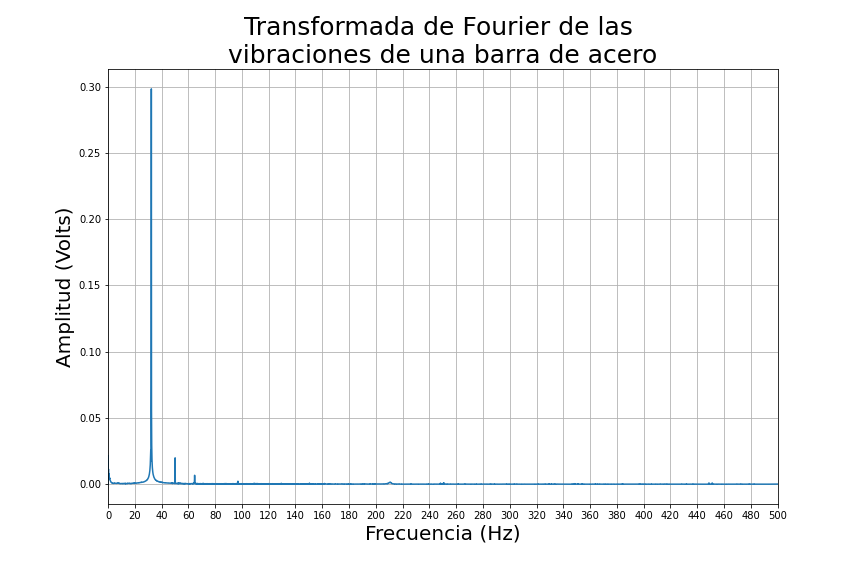

In [7]:
#filtro fourier
%matplotlib  nbagg

t_data = data[:,0]
v_data = data[:,1]

N = len(t_data)
t_max = t_data[-1]

fsamp = N/t_max

v_fft = np.fft.fft(v_data)
v_fft_2 = 2/N * np.abs(v_fft[:N//2])

frecuencia = np.linspace(0, fsamp/2, int(N/2))

fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(frecuencia, np.abs(v_fft_2))
ax.set_xlim([0,500])
ax.grid()
ax.set_xticks(np.arange(0,520,20))
ax.set_title("Transformada de Fourier de las \nvibraciones de una barra de latón", fontsize=25)
ax.set_ylabel("Amplitud (Volts)", fontsize=20)
ax.set_xlabel("Frecuencia (Hz)", fontsize=20)
plt.show()

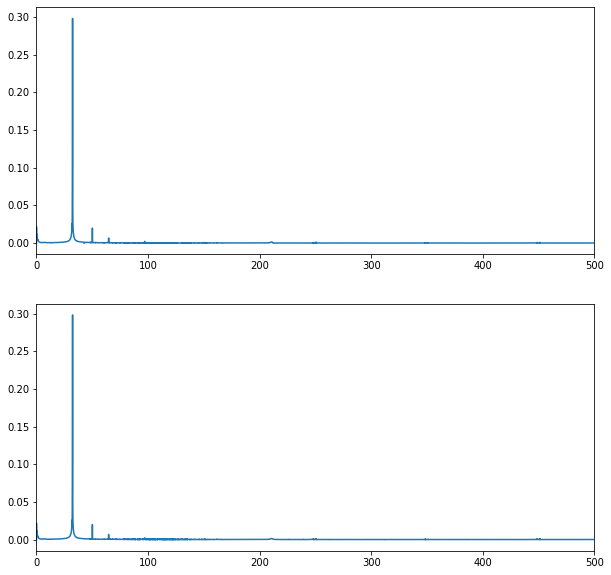

In [14]:
v_fft_filtrado = np.copy(v_fft)
v_fft_2_filtrado = np.copy(v_fft_2)
for n in range(10):
    v_fft_filtrado[1060*(n+1) : 1080*(n+1) ] = 0
    v_fft_2_filtrado[1060*(n+1) : 1080*(n+1)] = 0

fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(frecuencia, np.abs(v_fft_2_filtrado))
ax[1].plot(frecuencia, np.abs(v_fft_2))
ax[0].set_xlim([0,500])
ax[1].set_xlim([0,500])
plt.show()

/home/dina/environments/labo_4/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


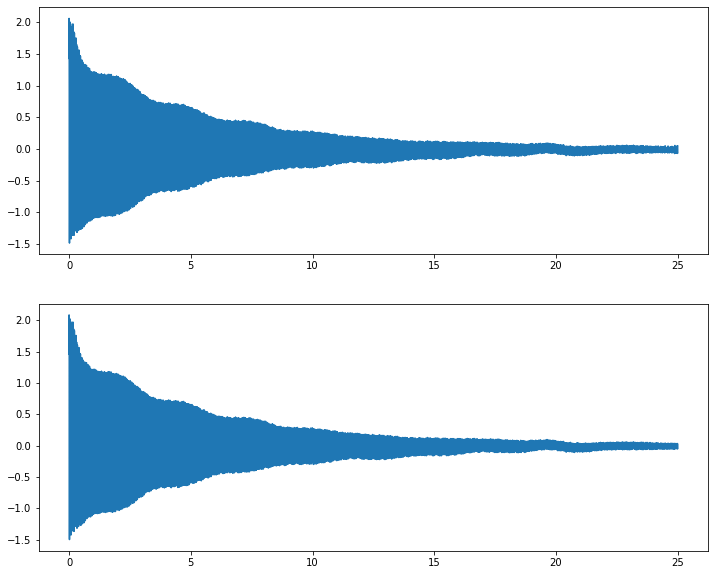

In [15]:
anti_transf_filt = np.fft.ifft(v_fft_filtrado)
anti_transf = np.fft.ifft(v_fft)

fig, ax = plt.subplots(2, figsize=(12,10))
ax[0].plot(t_data, anti_transf_filt)
ax[1].plot(t_data, v_data)
plt.show()

In [228]:

def v(t, A, w, fi, seda):
    v = np.zeros(t.size)
    for i in range(len(A)):
        v = v + A[i] * np.sin(w[i] * t + fi[i]) * np.exp(-seda * w[i] * t)
    #amp_luz = 0.028 * un.volts
    modos_luz = 5
    amp_luz = [0, 0, 0, 0.03, 0] * un.volts
    for i in range(modos_luz):
        w_luz = (2*i + 1) * 50 / un.second
    #    v = v + amp_luz[i] * np.sin(2*np.pi * w_luz * t)
    noise = np.random.normal(0, 1, int(1/tstep))
    #v = v + 0.005 * noise * un.volt
    return v

tstep = 0.00001
t = np.linspace(0, 20, int(1/tstep)) * un.second
fi = [0,0,0,0] * un.radian
A = np.array([1.35,0.1,0.01,0]) * un.volts

w = w_l
print(np.array(w, dtype=object) / (2*np.pi))
seda = 0.00075

w = np.array(w, dtype=object) * (1 - seda * np.ones(len(w)))
print(w/ (2*np.pi))
v_sim = v(t, A, w, fi, seda)



[<Quantity(35.1299517, '1 / second')> <Quantity(220.155653, '1 / second')>
 <Quantity(616.442169, '1 / second')> <Quantity(1207.98059, '1 / second')>]
[<Quantity(35.1036042, '1 / second')> <Quantity(219.990536, '1 / second')>
 <Quantity(615.979837, '1 / second')> <Quantity(1207.07461, '1 / second')>]


<ipython-input-228-828059496b62>:21: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  print(np.array(w, dtype=object) / (2*np.pi))
<ipython-input-228-828059496b62>:24: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  w = np.array(w, dtype=object) * (1 - seda * np.ones(len(w)))


<ipython-input-229-cc1b4615d848>:2: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  v_fft_teorico = np.fft.fft(np.array(v_sim))
/home/dina/environments/labo_4/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


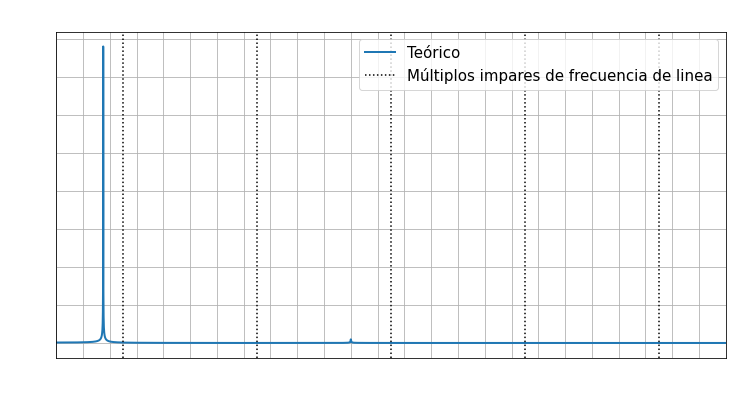

In [229]:
%matplotlib inline
v_fft_teorico = np.fft.fft(np.array(v_sim))
v_fft_2_teorico = 2/N * np.abs(v_fft_teorico[:N//2])

fsamp = N/t[-1]
frecuencia_sim = np.linspace(0, fsamp/2, int(N/2))

fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(frecuencia_sim, np.abs(v_fft_2_teorico), linewidth=2, label="Teórico")
ax.set_xlim([0,500])
ax.set_title("Transformada de Fourier de los datos teóricos", fontsize=25, color="w")
ax.set_xlabel("Frecuencia (Hz)", fontsize=20, color="w")
ax.set_ylabel("Amplitud (Volts)", fontsize=20, color="w")
ax.grid()
ax.set_xticks(np.arange(0,520,20))
ax.tick_params(colors="w", labelsize=12, rotation=0)
ax.axvline(50, linestyle="dotted", color="black", label="Múltiplos impares de frecuencia de linea")
ax.axvline(150, linestyle="dotted", color="black")
ax.axvline(250, linestyle="dotted", color="black")
ax.axvline(350, linestyle="dotted", color="black")
ax.axvline(450, linestyle="dotted", color="black")

plt.legend(fontsize=15)
plt.show()


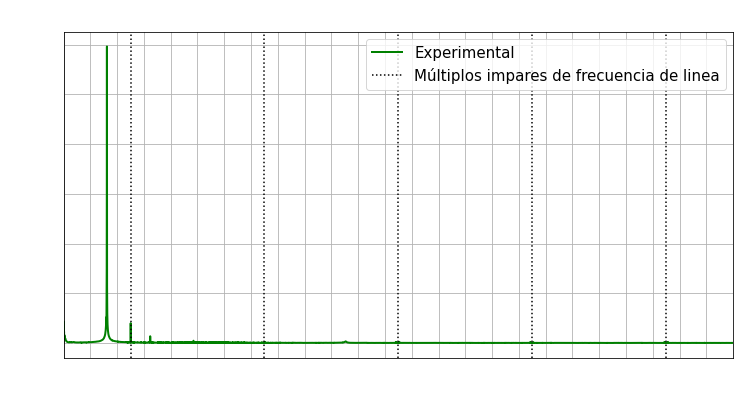

In [230]:
%matplotlib inline

fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(frecuencia, np.abs(v_fft_2), linewidth=2, label="Experimental", color="green")
ax.set_xlim([0,500])
ax.set_title("Transformada de Fourier de los datos experimentales", fontsize=25, color="white")
ax.set_xlabel("Frecuencia (Hz)", fontsize=20, color="white")
ax.set_ylabel("Amplitud (Volts)", fontsize=20, color="white")
ax.grid()
ax.set_xticks(np.arange(0,520,20))
ax.tick_params(colors="w", labelsize=12, rotation=0)
ax.axvline(50, linestyle="dotted", color="black", label="Múltiplos impares de frecuencia de linea")
ax.axvline(150, linestyle="dotted", color="black")
ax.axvline(250, linestyle="dotted", color="black")
ax.axvline(350, linestyle="dotted", color="black")
ax.axvline(450, linestyle="dotted", color="black")
plt.legend(fontsize=15)
plt.show()

<ipython-input-231-269f9aff2a6a>:4: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  t_graf = np.array(t)
<ipython-input-231-269f9aff2a6a>:5: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  v_graf = np.array(v_sim) #+ offset
/home/dina/environments/labo_4/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


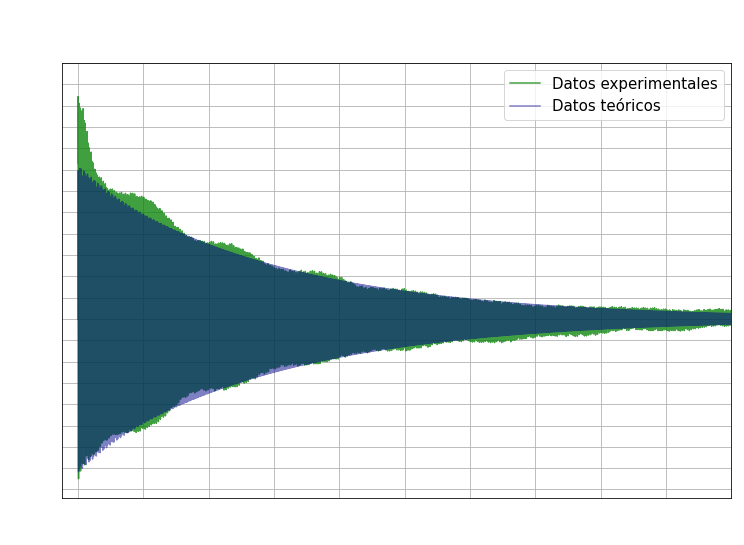

In [231]:
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(12,8))

t_graf = np.array(t)
v_graf = np.array(v_sim) #+ offset

#ax.plot(t_data, anti_transf_filt, color='red')
ax.plot(t_data, anti_transf, color="green", alpha=0.75, label="Datos experimentales")
ax.plot(t_graf, v_graf, color="darkblue", alpha=0.5, label="Datos teóricos")
ax.set_xlabel("Tiempo (s)", fontsize=20, color="w")
ax.set_ylabel("Amplitud (V)", fontsize=20, color="w")
ax.grid()
ax.set_title("Diferencia de potencial en función del tiempo\n para la vara de latón", fontsize=25, color="w")
ax.set_xlim([-0.5,20])
ax.set_xticks(np.arange(0,22,2))
ax.set_yticks(np.arange(-1.6, 2.5, 0.2))
#ax.set_ylim([-0.6, 0.7])
ax.tick_params(colors="w")
plt.legend(fontsize=15)
plt.show()
